# <center>Big Data &ndash; Exercises &ndash; Solution</center>
## <center>Fall 2021 &ndash; Week 7 &ndash; ETH Zurich</center>
## <center>MapReduce</center>


Reading: 
- White, T. (2015). Hadoop: The Definitive Guide (4th ed.). O’Reilly Media, Inc. [ETH library] (Chapters 2, 6, 7, 8: mandatory, Chapter 9: recommended)

- George, L. (2011). HBase: The Definitive Guide (1st ed.). O’Reilly. [ETH library] (Chapter 7: mandatory).

- Original MapReduce paper: [MapReduce: Simplified Data Processing on Large Clusters](https://static.googleusercontent.com/media/research.google.com/en//archive/mapreduce-osdi04.pdf) (mandatory)



This exercise will consist of 2 main parts: 
* Hands-on practice with MapReduce on Azure HDInsight
* Architecture and theory of MapReduce

## 1. Setup a cluster

### Create an Hadoop cluster

Start the Hadoop cluster (in pseudo-distributed mode), similar to the HDFS exercise session, by running:

```
sudo docker-compose up
```

Wait for a couple minutes until the terminal no longer outputs startup logs.

## 2. Write a Word Count MapReduce job
We want to find which are the most frequently-used English words. To answer this question, we prepared a big text files (1.2GB) where we concatenated the 3,036 books of the [Gutenberg dataset](http://web.eecs.umich.edu/~lahiri/gutenberg_dataset.html). 

### 2.1 Load the dataset

The dataset we provide consists of a concatenation of 3,036 books (`gutenberg.txt`). However we provide 3 versions:

- `gutenberg_x0.1.txt` - a smaller dataset of about 120MB
- `gutenberg.txt` - the original dataset, 1.2GB
- `gutenberg_x10.txt` - a bigger dataset of 12GB. ** This is optional. Load and process this only after you finished the exercise with the first two. Be aware that it might take some time.**

Follow the steps below to set this dataset up in HDFS:
 - Log in into the NameNode container by launching a shell on it:
 
```bash
docker exec -it namenode /bin/bash
```

 - Download the dataset from our storage to the local filesystem of the NameNode using `curl -O` (capital O - like Orange):
 
```bash
curl -O https://bigdata2020exassets.blob.core.windows.net/ex07/gutenberg_x0.1.txt
curl -O https://bigdata2020exassets.blob.core.windows.net/ex07/gutenberg.txt
curl -O https://bigdata2020exassets.blob.core.windows.net/ex07/gutenberg_x10.txt
```

 - Load the dataset into the HDFS filesystem:
 


With `ls -lh` you should see the 2 files mentioned above. These files are now in the "local" (remember, we are in containers) hard drive of your NmaeNode.

Upload the files into HDFS where they can be consumed by MapReduce:

```bash
hdfs dfs -copyFromLocal *.txt /
``` 

### 2.2 Understand the MapReduce Java API

We wrote a template project that you can use to experiment with MapReduce. Download **on your local machine, not in the container** and unzip the following package.

```bash
curl -O https://bigdata2020exassets.blob.core.windows.net/ex07/mapreduce.zip
unzip mapreduce.zip
docker cp mapreduce namenode:/mapreduce
```

*Note: Before you docker cp, make sure you remove the old mapreduce directory from the NameNode*

Now examine the content of the the `src` folder. You will see one Java class:
- *MapReduceWordCount*: a skeleton for a MapReduce job that loads data from file

Start looking at *MapReduceWordCount*. You can see that the *main* method is already provided. Our `WordCountMapper` and `WordCountReducer` are implemented as classes that extend Hadoop's `Mapper` and `Reducer`. For this exercise, you only need to consider (and override) the `map()` method for the mapper and the `reduce()` method for the reducer.

```java
public class Mapper<KEYIN, VALUEIN, KEYOUT, VALUEOUT> {

    protected void map(KEYIN key, VALUEIN value, Mapper<KEYIN, VALUEIN, KEYOUT, VALUEOUT>.Context context) {
        context.write(key, value);
    }
}
```

```java
public class Reducer<KEYIN, VALUEIN, KEYOUT, VALUEOUT> {
    protected void reduce(KEYIN key, Iterable<VALUEIN> values, Reducer<KEYIN, VALUEIN, KEYOUT, VALUEOUT>.Context context) {
        Iterator var4 = values.iterator();

        while(var4.hasNext()) {
            Object value = var4.next();
            context.write(key, value);
        }

    }
}
```

Consulting the [documentation](http://hadoop.apache.org/docs/stable/hadoop-mapreduce-client/hadoop-mapreduce-client-core/MapReduceTutorial.html) if necessary, answer the following questions:

1. What are possible types for `KEYIN, VALUEIN, KEYOUT and VALUEOUT`? Should `KEYOUT` and `VALUEOUT` for the Mapper be the same as `KEYIN` and `VALUEIN` for the Reducer?
1. What is the default behavior of a MapReduce job running the base Mapper and Reducer above?
1. What is the role of the object `Context`?

### Solution
1. Since the output of mapper and reducer must be serializable, they have to implement the [Writable interface](http://hadoop.apache.org/docs/stable/api/org/apache/hadoop/io/Writable.html). Additionally, the key classes have to implement the [WritableComparable interface](http://hadoop.apache.org/docs/stable/api/org/apache/hadoop/io/WritableComparable.html) to facilitate sorting by the framework. Hadoop provides classes implementing these interfaces for string, boolean, integers, long and short values.
1. Mapper and Reducers are identity functions. Since there is always a shuffling phase, the overall job performs sorting by input key.
1. [Context](http://hadoop.apache.org/docs/r3.0.0-alpha2/api/index.html) allows the Mapper/Reducer to interact with the rest of the Hadoop system. It includes configuration data for the job and the methods for mapper and reducer to emit output (`write()`). Applications can also use the Context to set parameters to mappers and reducers runnning on different nodes.

### 2.2 Write and run your MapReduce wordcount

Edit the provided skeleton and implement mapper and reducer to implement a word count. The goal is to know how many times each unique word appears in the dataset. You can consider each word as a sequence of characters separated by a whitespace, or implement a more sophisticated tokenizer if you wish.

- Can you use your Reducer as Combiner? If so enable it by uncommenting the appropriate line in the `main` method.

Once you are confident on your solution you can transfer it back to the container, compile it and run it, from the **mapreduce/src** folder.

```bash
javac *.java -cp $(hadoop classpath)
jar cvf MapReduceWordCount.jar *.class 
```

Inside the you will now find `MapReduceWordCount.jar`.
Run the map reduce job on the cluster using:

```bash
yarn jar MapReduceWordCount.jar MapReduceWordCount /gutenberg.txt /tmp/results
```

To get the results after the job is done, simply copy to local the directory with the resuts:
```
hdfs dfs -copyToLocal /tmp/results
```

<br>The process is very similar to the one for HBase of last week. Answer the following questions:

1. Run the MapReduce job on the cluster with the default configuration and 4 DataNodes using using only the medium size Gutenberg file for now. *(Note: if you want to run your job again, you first need to delete the previous result folder because Hadoop refuses to write in the same location)*: 
```
hdfs dfs -rm -r <path-to-hdfs-output-folder>
```
2. How many map and reduce tasks were created with the default configuration?
3. Does it go faster with more reduce tasks? Experiment with `job.setNumReduceTasks()`. What is the disadvantage of having multiple reducers? (Hint: check the format of your output)

### Solution

A possible solution is the one below. Notice that this Reducer can be also used as a Combiner.

**Mapper**
```java
private static class WordCountMapper extends Mapper<Object, Text, Text, IntWritable>{

        private final static IntWritable one = new IntWritable(1);
        private Text word = new Text();

        public void map(Object key, Text value, Context context) throws IOException, InterruptedException {
            StringTokenizer itr = new StringTokenizer(value.toString());
            while (itr.hasMoreTokens()) {
                word.set(itr.nextToken());
                context.write(word, one);
            }
        }
    }
```

**Reducer**
```java
private static class WordCountReducer extends Reducer<Text,IntWritable,Text,IntWritable> {

        private IntWritable result = new IntWritable();

        public void reduce(Text key, Iterable<IntWritable> values, Context context) throws IOException, InterruptedException {
            int sum = 0;
            for (IntWritable val : values) {
                sum += val.get();
            }
            result.set(sum);
            context.write(key, result);
        }
    }
```

1. Some figures are provided below.
1. In my case, the number of map tasks was 3 and the number of reduce tasks 1. By default, the number of map tasks for a given job is driven by the number of input splits. The parameter `mapred.map.tasks` can be used to set a *suggested* value. For reduce tasks, 1 is the default number. This might be a bad choice in terms of performance, but on the other hand the result will be on a single file, without further merging necessary.

1. Generally, one reducer might become a bottleneck. In this case, the bottleneck is more evident if no combiner is used. However, using multiple reducers, multiple output files will be created and an additional merging step is necessary to get the same result. Note: according to the official documentation, the right number of reduces is 0.95 or 1.75 multiplied by [no. of nodes] * [no. of maximum containers per node].
With 0.95 all of the reduces can launch immediately and start transferring map outputs as the maps finish. With 1.75 the faster nodes will finish their first round of reduces and launch a second wave of reduces doing a much better job of load balancing. The scaling factors above are slightly less than whole numbers to reserve a few reduce slots in the framework for speculative-tasks and failed tasks.

### 2.3. Plot the results
By default, output files have the form `part-A-XXXX` where `A` is *r* or *m* to denote Reducer or Mapper outputs, and `XXXX` is the id of the specific mapper or reducer task.

To plot the results, copy the file from the Docker container to your local machine, and then run the script below.

```bash
docker cp namenode:/path_to_results results
```

In [ ]:
import matplotlib.pyplot as plt
import operator
print ('Plotting...')
freq = {}

# Read input and sort by frequency. Keep only top 30.
with open('results.txt', 'rb') as csvfile:
    for line in csvfile.readlines():
        word, count = line.decode('UTF-8').split('\t')
        freq[word] = int(count)
srt = sorted(freq.items(), key=operator.itemgetter(1), reverse=True)[:30]

# Generate plot
plt.figure(figsize=(16,6))
plt.bar(range(len(srt)), [x[1] for x in srt], align='center', color='#ba2121')
plt.xticks(range(len(srt)), [x[0] for x in srt])
plt.show()

In everything is correct, the 3 most frequent words should be **`the`**, **`of`** and **`and`**.

## 3. Performance comparison

- Test your MapReduce with the smaller `gutenberg_x0.1.txt` as well. If you want, you can also try with `gutenberg_x10.txt`. For each test, **write down the running time**:

```
time yarn jar MapReduceWordCount.jar MapReduceWordCount /tmp/gutenberg_x0.1.txt /tmp/gut01/
time yarn jar MapReduceWordCount.jar MapReduceWordCount /tmp/gutenberg.txt /tmp/gut1/
time yarn jar MapReduceWordCount.jar MapReduceWordCount /tmp/gutenberg_x10.txt /tmp/gut10/
```


- Download the dataset on your laptop. **Note: the bigger file is optional. You need at least 12.5GB of free space in your hard drive, and will take some time to download and process!**
Alternatively, you can also run this experiment on the NameNode of your cluster, where you should still have the text files.


- We prepared a simple [wordcount program](https://bigdata2020exassets.blob.core.windows.net/ex07/python_wordcount.zip) in Python. Download it on your laptop (or the cluster NameNode) and test how long it takes to process the three datasets. **Annotate the times for the next exercise.**
    
```
python wordcount.py < /pathtoyourfile/gutenberg_x0.1.txt
python wordcount.py < /pathtoyourfile/gutenberg.txt
python wordcount.py < /pathtoyourfile/gutenberg_x10.txt
```
    
### 3.1 Plot
Compare the performance of the MapReduce vs the single-thread implementation of the word count algorithm for the three different input sizes. Fill the time in seconds in the code below to plot the results.

In [ ]:
# NOTE: remove the last number on the lists below if you did not test gutenberg_x10.txt
size_input = [1.2*10e2, 1.2*10e3, 1.2*10e4] # the input size in MB
time_mapreduce = [0., 0., 0.] # replace 0s with the time (in seconds) for the corresponding inputs
time_locallaptop = [0., 0., 0.] # replace 0s with the time (in seconds) for the corresponding inputs


%matplotlib inline
# Import plot library
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(18,9))
plt.plot(size_input, time_mapreduce, '#f37626', label='MapReduce', linewidth=3.0)
plt.plot(size_input, time_locallaptop, '#00b300', label='Local laptop', linewidth=3.0, linestyle='dashed')

plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Input size (MB)')
plt.ylabel('Time (seconds)')
plt.title('Wall-time comparison')
plt.show()

### 3.2. Discussion

We have run some more tests. Here we present the running time for 3 configurations on HDInsight, one workstation and one laptop. The figures below are indicative only, because the performance of every machine depends on several factors.

- **MapReduce v1**: no combiner with default configuration (1 reducer)
- **MapReduce v2**: no combiner with 8 reduce tasks
- **MapReduce v3**: using combiner with default configuration (1 reducer)
- **MapReduce v4**: using combiner with 8 reduce tasks
- **Workstation**: using a local workstation (server)
- **Laptop**: using a local laptop

See our performance plot below:

<img src="https://bigdata2020exassets.blob.core.windows.net/ex07/performance.png" style="width:100px;">

1. Which line corresponds to which setting?
1. Which is faster, MapReduce on your cluster or a local wordcount implementation? Why?
2. Based on your experiment, what input size is the approximate break-even point for time performance?
3. Why MapReduce is not performing better than local computation for small inputs?
4. How can you optimize the MapReduce performance for this job?

### Solution

We have run some more tests. Here we present the running time for 3 configurations on HDInsight, one workstation and one laptop. The figures below are indicative only, because the performance of every machine depends on several factors. 

- **MapReduce v1**: no combiner with default configuration (1 reducer)
- **MapReduce v2**: no combiner with 8 reduce tasks
- **MapReduce v3**: using combiner with default configuration (1 reducer)
- **MapReduce v4**: using combiner with 8 reduce tasks


1. See figure below
1. For small inputs, local computation is faster
2. Using a combiner, MapReduce gets faster than a single workstation somewhere between 1GB and 10GB of data. This of course, really depends on the task and the configuration of the machines.
3. The shuffling phase adds a lot of overhead computation
4. A combiner drastically improves the performance for this job where the data to be shuffled can be reduced a lot

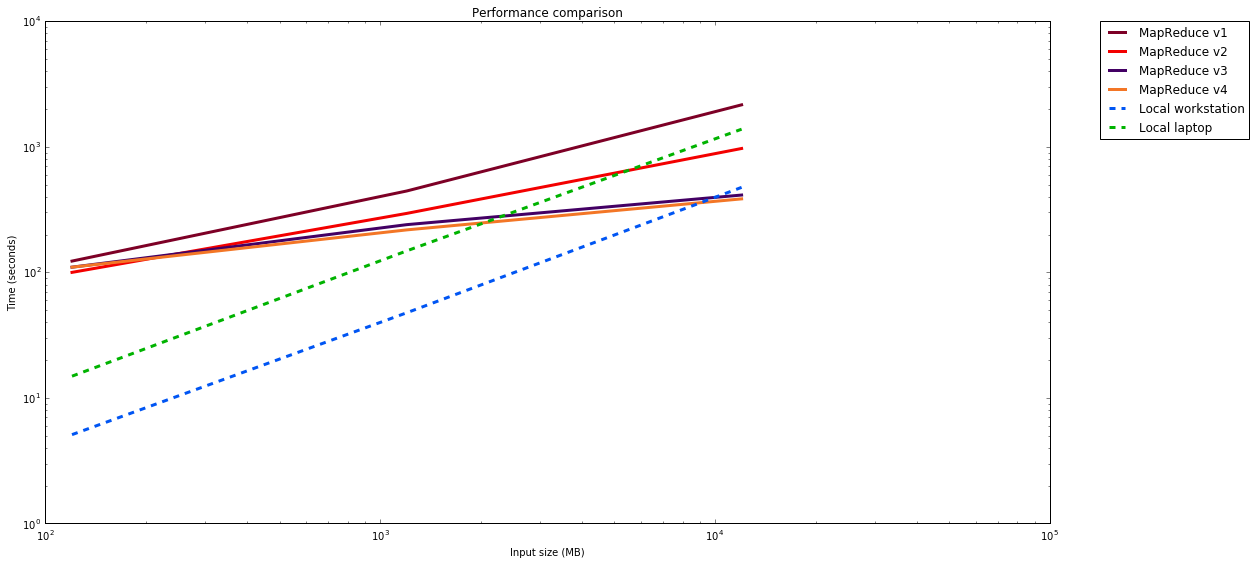

In [ ]:
size_input = [1.2*1e2, 1.2*1e3, 1.2*1e4] # the input size in MB
time_mapreduce1 = [123, 445, 2160] # MapReduce v1
time_mapreduce2 = [100, 295, 970] # MapReduce v2
time_mapreduce3 = [110, 240, 413] # MapReduce v3
time_mapreduce4 = [110, 218, 385] # MapReduce v4
# 11.4, 127, 1332
#time_localstation = [11.4, 127, 1332] # our workstation (java)
time_localstation = [5.1, 47.7, 475.5] # our workstation
time_locallaptop = [14.9, 148.4, 1381.7] # our laptop


%matplotlib inline
# Import plot library
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(18,9))
plt.plot(size_input, time_mapreduce1, '#7d0026', label='MapReduce v1', linewidth=3.0)
plt.plot(size_input, time_mapreduce2, '#f30000', label='MapReduce v2', linewidth=3.0)
plt.plot(size_input, time_mapreduce3, '#430064', label='MapReduce v3', linewidth=3.0)
plt.plot(size_input, time_mapreduce4, '#f37626', label='MapReduce v4', linewidth=3.0)

plt.plot(size_input, time_localstation, '#0055f3', label='Local workstation', linewidth=3.0, linestyle='dashed')
plt.plot(size_input, time_locallaptop, '#00b300', label='Local laptop', linewidth=3.0, linestyle='dashed')

plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Input size (MB)')
plt.ylabel('Time (seconds)')
plt.title('Performance comparison')
plt.show()

## 4. Querying JSON: The Language Confusion Dataset (optional)

In this task, we will develop a MapReduce application that processes a dataset from the [language game](https://lars.yencken.org/datasets/languagegame/).
It contains rows of the following format:

```json
{"target": "Turkish",
 "sample": "af0e25c7637fb0dcdc56fac6d49aa55e",
 "choices": ["Hindi", "Lao", "Maltese", "Turkish"],
 "guess": "Maltese",
 "date": "2013-08-19",
 "country": "AU"}
```

Here, the `guess` field is what the user chose and the `target` field was the expected answer.

### 4.1. Set up

- Attach to the NameNode container:  `docker exec -it namenode /bin/bash`
- Download the data **on your local machine, not in the container**: `curl -O http://data.greatlanguagegame.com.s3.amazonaws.com/confusion-2014-03-02.tbz2`
- Extract the data: `tar -jxvf confusion-2014-03-02.tbz2`
- Copy the data to the NameNode container: `docker cp confusion-2014-03-02 namenode:/confusion-2014-03-02`
- Upload the data to HDFS: `hdfs dfs -put confusion-2014-03-02/confusion-2014-03-02.json /tmp/`

### 4.2. Query implementation

- You can start with the code provided in Task 3. <br> Download the initial code `curl -O https://exerciseassets.blob.core.windows.net/exercise06/mapreduce.zip` and modify it accordingly.
- On the NameNode container, remove the old mapreduce directory: `rm -rf /mapreduce_path`
- The query to be implemented is:

**Find the number of games where the guessed language is correct (i.e., guess equal to the target one) and that language is Russian.**

- To parse a line of text, first add the next to the other imports:
```java
import com.google.gson.JsonObject;
import com.google.gson.JsonParser;
```

- Then, you can use the following to parse and access json elements:

```java
...
    JsonObject jsonObject = new JsonParser().parse(value.toString()).getAsJsonObject();
    jsonObject.get("target").getAsString();
...
```

To compile and run the code, follow the same steps as above for Exercise 2.2.
**Note: Make sure that the path to the json is the one on HDFS, not the one in the local container.**

#### Solution:

A possible solution is the one below. Notice that this Reducer can be also used as a Combiner.

**Mapper**
```java
private static class WordCountMapper extends Mapper<Object, Text, Text, IntWritable>{

        private final static IntWritable one = new IntWritable(1);
        private Text word = new Text();

        public void map(Object key, Text value, Context context) throws IOException, InterruptedException {
            JsonObject jsonObject = new JsonParser().parse(value.toString()).getAsJsonObject();
            if (jsonObject.get("target").getAsString().equals(jsonObject.get("guess").getAsString()) &&
                    jsonObject.get("target").getAsString().equals("Russian")) {
                word.set("Russian");
                context.write(word, one);
            }
        }
    }
```

**Reducer**

The same reducer as in the previous task can be used.

## 5. Reverse engineering
Conceptually, a map function takes an input a key-value pair and emits a list of key-values pairs, while a reduce function takes in input a key with an associated list of values and returns a list of values or key-value pairs. Often the type of the final key and value is the same of the type of the intermediate data:

- map     `(k1,v1) --> list(k2,v2)`
- reduce  `(k2,list(v2))--> list(k2, v2)`


Analyze the following Mapper and Reducer, written in pseudo-code, and answer the questions below.

```js
function map(key, value)
  emit(key, value);
```

```js
function reduce(key, values[])
  z = 0.0
  for value in values:
    z += value
  emit(key, z / values.length())
```

**Questions**

1. Explain what is the result of running this job on a list of pairs with type ([string], [float]).
1. Write the equivalent SQL query.
1. Could you use this reduce function as combiner as well? Why or why not?
1. If your answer to the previous question was *yes*, does the number of different keys influences the effectiveness of the combiner? If you answer was *no*, can you change the map and reduce functions in such a way the new reducer the can be used as combiner?

### Solution

1. This will output a pair `(k1, v1)` for each unique input key, where `k1` is the input key and `v1` is the average of the values associated with `k1`.
1. Equivalent to `SELECT key, AVG(value) FROM tablename GROUP BY key`.
1. No, because the average operation is not associative.
1. If we allow the final output to contain an additional piece of information (how many samples the average represents), the reducer can be used as combiner, with the values being themselves a pair:

```js
function map(key, value)
  emit(key, (1, value));
```

```js
function reduce(key, values[])
  n = 0
  z = 0.0
  for value in values:
    n += value[0]
    z += value[0] * value[1]
  emit(key, (n, z / n))
```

## 6. True or False
Say if the following statements are *true* or *false*, and explain why.

1. Each mapper must generate the same number of key/value pairs as its input had.
1. The TaskTracker is responsible for scheduling mappers and reducers and make sure all nodes are correctly running.
1. The input key/value pairs of mappers are sorted by the key.
1. MapReduce splits might not correspond to HDFS block.
1. One single Reducer is applied to all values associated with the same key.
1. Multiple Reducers can be assigned pairs with the same value.
1. In Hadoop MapReduce, the key-value pairs a Reducer outputs must be of the same type as its input pairs.

### Solution

1. **False** - for each input pair, the mapper can emit zero, one, or several key/value pairs.
1. **False** - the JobTracker is responsible for this.
1. **False** - mapper input is not sorted.
1. **True** - since splits respects logical record boundaries, they might contain data from multiple HDFS blocks.
1. **True** - this is the principle behind partitioning: one Reducer is responsible for all values associated with a particular key.
1. **True** - values are not relevant in partitioning.
1. **False** - Reducer's input and output pairs might have different types.

## 7. Some more MapReduce and SQL

Design, in Python or pseudo-code, MapReduce functions that take a very large file of integers and produce as output:

1. The largest integer.
1. The average of all the integers.
1. The same set of integers, but with each integer appearing only once.
1. The number of times each unique integer appears.
1. The number of distinct integers in the input.

For each of these, write the equivalent SQL query, assuming you have a column `values` that stores all the integers.

### Solution

1) **SELECT MAX(values) ...** - Naive solution, very low degree of parallelization. We can use a Combiner (identical to Reducer) to increase the degree of parallelization.

```js
function map(key, value)
  emit(1, key); //group everything on the same key
```

```js
function reduce(key, values[])
  global_max = 0
  for value in values:
    if (value > global_max):
      global_max = value
  emit(global_max)
```

2) **SELECT AVG(values) ...** - using the same Map above

```js
function reduce(key, values[])
  sum, count = 0
  for value in values:
    sum += value
    count += 1
  emit(sum / count)
```

3) **SELECT DISTINCT values ...**
```js
function map(key, value)
  emit(key, 1)
```

```js
function reduce(key, values[])
  emit(key)
```

4) **SELECT values, COUNT (*) ... GROUP BY values.**
```js
function map(key, value)
  emit(key, 1)
```

```js
function reduce(key, values[])
  emit(key, len(values))
```

5) **SELECT COUNT (DISTINCT values) ...**

Reuse (3) and add a postprocessing step to combine the output of the reducers. A second MapReduce stage could also be used but it would probably be an overkill for this scenario.

## 8. TF-IDF in MapReduce (optional)
Imagine we want to build a search engine over the Gutenberg dataset of ~3000 books. Given a word or a set of words, we want to rank these books according their relevance for these words. We need a metric to measure the importance of a word in a set of document...

### 8.1 Understand TF-IDF

[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a statistic to determine the relative importance of the words in a set of documents. It is computed as the product of two statistics, term frequency (`tf`) and inverse document frequency (`idf`). 

Given a word `t`, a document `d` (in this case a book) and the collection of all documents `D` we can define `tf(t, d)` as the number of times `t` appears in `d`. This gives us some information about the content of a document but because some terms (eg. "the") are so common, term frequency will tend to incorrectly emphasize documents which happen to use the word "the" more frequently, without giving enough weight to the more meaningful terms.

The inverse document frequency `idf(t, D)` is a measure of how much information the word provides, that is, whether the term is common or rare across all documents. It can be computed as:

![idf](https://bigdata2020exassets.blob.core.windows.net/ex07/idf.png)

where $|D|$ is the total number of documents and the denominator represents how many documents contain the word $t$ at least once. However, this would cause a division-by-zero exception if the user query a word that never appear in the dataset. A better formulation would be:

![idf](https://bigdata2020exassets.blob.core.windows.net/ex07/idf_smooth.png)

Then, the `tdidf(t, d, D)` is calculated as follows:

![idf](https://bigdata2020exassets.blob.core.windows.net/ex07/tfidf.png)

A high weight in `tfidf` is reached by a high term frequency (in the given document) and a low document frequency of the term in the whole collection of documents.

### 8.2 Implement TF-IDF in MapReduce (pseudo-code)
Implement Mapper and Reducer functions in pseudo-code to compute TF-IDF. Assume each Mapper receives the document name as string key and the entire document content as string value. The output of your job should be a list of key-value pairs, where the key is a string in the form "document:word" and the value is the `tfidf` score for that document/word pair.

```js
function map(doc_id, doc_content)
  ...
```

```js
function reduce(key, values[])
  ...
```

### Solution
1) Mapper outputs each word-document pair

```js
function map(doc_id, doc_content)
  tokens = doc_content.split()
  for token in tokens:
    emit(token, (doc_id, 1)); 
```

2) An optional combiner performs an aggregation over all occurrences of the same word per document
```js
function combiner(token, values)
  frequencies = {} //empty dictionary
  for (doc_id, count) in values:
    frequencies[doc_id] += count //list of documents should fit in memory
  for doc_id in frequencies.keys():
    emit(token, (doc_id, frequencies[doc_id])); 
```

3) A Reducer is called for each unique word in the collection and outputs a list of document:word pairs with the tf-idf score
```js
function reduce(token, values[])
  frequencies = {} //empty dictionary
  for (doc_id, count) in values:
    frequencies[doc_id] += count //list of documents should fit in memory
  idf = log(N/(1+frequencies.keys().length())) // idf for token
  for doc_id in frequencies.keys():
    tf = frequencies[doc_id] // tf for token-docid pair
    emit(doc_id + ":" + token, tf*idf)
```